## Question 4: Quantization
Please also consult the HW PDF to know the specific things you need to do.

## Initial Setup

Before beginning the assignment, we import the CIFAR dataset, and train a simple convolutional neural network (CNN) to classify it.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Load training and test data from the CIFAR10 dataset.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s] 


Define a simple CNN that classifies CIFAR images.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [5]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [6]:
train(net, trainloader)

[1,  2000] loss: 2.221
[1,  4000] loss: 1.901
[1,  6000] loss: 1.686
[1,  8000] loss: 1.568
[1, 10000] loss: 1.553
[1, 12000] loss: 1.516
[2,  2000] loss: 1.447
[2,  4000] loss: 1.410
[2,  6000] loss: 1.383
[2,  8000] loss: 1.350
[2, 10000] loss: 1.335
[2, 12000] loss: 1.337
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

In [7]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 53.22%


In [8]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

## Question 1: Visualize Weights

In [9]:
import matplotlib.pyplot as plt
import numpy as np

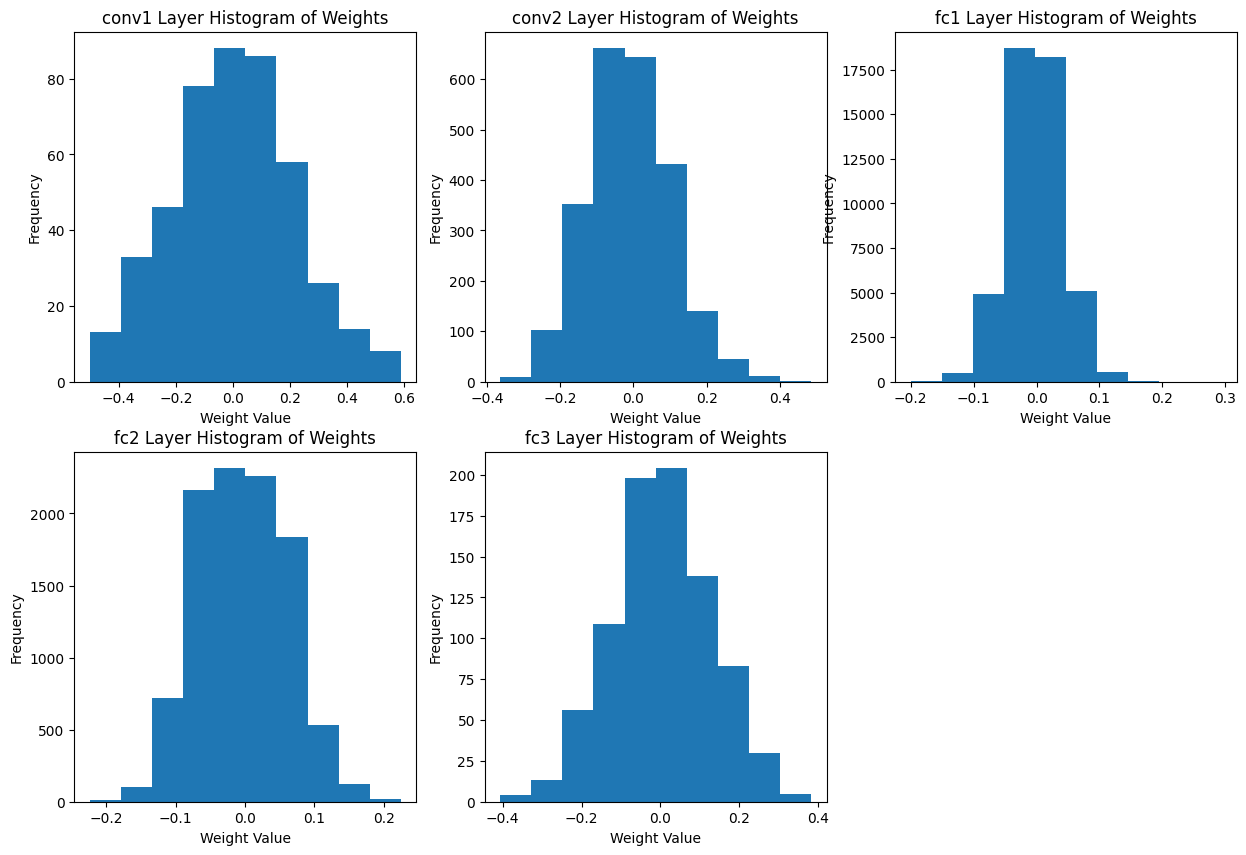

conv1
Range: (-0.50060385, 0.5876992)
Mean: 0.0012284977
Standard Deviation: 0.21102612


conv2
Range: (-0.3643383, 0.48578006)
Mean: -0.010588029
Standard Deviation: 0.11290347


fc1
Range: (-0.20037553, 0.29379752)
Mean: -0.0024880795
Standard Deviation: 0.04287504


fc2
Range: (-0.22354394, 0.22480442)
Mean: -0.0031889004
Standard Deviation: 0.06426893


fc3
Range: (-0.4064013, 0.38186222)
Mean: 0.0037882142
Standard Deviation: 0.12598744




In [13]:
# Plot histograms of weights for each layer

# Get a flattened vector of the weights for each layer
layers = {
    'conv1': net.conv1.weight.data.cpu().view(-1),
    'conv2': net.conv2.weight.data.cpu().view(-1),
    'fc1': net.fc1.weight.data.cpu().view(-1),
    'fc2': net.fc2.weight.data.cpu().view(-1),
    'fc3': net.fc3.weight.data.cpu().view(-1)
}
statistics = {
    'conv1': {},
    'conv2': {},
    'fc1': {},
    'fc2': {},
    'fc3': {}
}

# Create subplots for histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Convert multi-dimensional subplot axes array into a 1D array
axes = axes.flatten()
i = 0
for key in layers:
    # Get layer name and weights
    layer_name = key
    layer_weights = layers[key]

    # Convert weights into a numpy array
    weights = layer_weights.numpy()

    # Store statistics(range, mean, std) for layer
    weights_range = (weights.min(), weights.max())
    statistics[key]['range'] = weights_range
    weights_mean = weights.mean()
    statistics[key]['mean'] = weights_mean
    weights_std = weights.std()
    statistics[key]['std'] = weights_std

    # Plot histogram of weights for layer
    axes[i].hist(weights)
    axes[i].set_title(layer_name + " Layer Histogram of Weights")
    axes[i].set_xlabel('Weight Value')
    axes[i].set_ylabel('Frequency')
    i += 1

# Remove the extra subplot
axes[-1].axis('off')
plt.show()

# Calculate and print statistical measures (range, mean, standard deviation) for each layer
for key in statistics:
    print(key)
    print("Range: " + str(statistics[key]['range']))
    print("Mean: " + str(statistics[key]['mean']))
    print("Standard Deviation: " + str(statistics[key]['std']))
    print()
    print()

In [15]:
# Analyze distribution patterns across layers
"""
The conv1 layer has the largest range and the highest variance. The conv2 layer has a narrower range and a variance that nearly havles the variance in the conv1 layer. The fc1 layer has an even tigher range and the smallest variance out of all the layers. The fc2 layer has a tigher range than the fc1 layer but a slightly larger variance at the same time. And the fc3 layer has a significantly wider range and almost double the variance of the fc2 layer.
"""

'\nThe conv1 layer has the largest range and the highest variance. The conv2 layer has a narrower range and a variance that nearly havles the variance in the conv1 layer. The fc1 layer has an even tigher range and the smallest variance out of all the layers. The fc2 layer has a tigher range than the fc1 layer but a slightly larger variance at the same time. And the fc3 layer has a significantly wider range and almost double the variance of the fc2 layer.\n'

Analyze distribution patterns across layers

The conv1 layer has the largest range and the highest variance. The conv2 layer has a narrower range and a variance that nearly havles the variance in the conv1 layer. The fc1 layer has an even tigher range and the smallest variance out of all the layers. The fc2 layer has a tigher range than the fc1 layer but a slightly larger variance at the same time. And the fc3 layer has a significantly wider range and almost double the variance of the fc2 layer.

## Question 2: Quantize Weights

In [14]:
net_q2 = copy_model(net)

In [18]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    # ADD YOUR CODE HERE
    # 3-Sigma clipping
    mean = weights.mean()
    std = weights.std()
    new_min = mean - (3 * std)
    new_max = mean + (3 * std)
    # Defining the range as mean +/- 3*std
    new_range = new_max - new_min
    # # Calculate scale((127 - -128) / range)
    scale = 255.0 / new_range
    # Clip weights, center them, and then scale them
    clipped_weights = torch.clamp(weights, new_min, new_max)
    result = ((clipped_weights - new_min) * scale - 128).round()
    return torch.clamp(result, min=-128, max=127), scale

In [49]:
# 3-Sigma Quantization strategy explanation
"""
The 3-Sigma Quantization strategy essentially just clips outliers in the weights/activations data that are beyong 3 standard deviations of the mean which still ensures that the remaining data covers around 99.7%(assuming it follows a normal distribution).
"""

'\nThe 3-Sigma Quantization strategy essentially just clips outliers in the weights/activations data that are beyong 3 standard deviations of the mean which still ensures that the remaining data covers around 99.7%(assuming it follows a normal distribution).\n'

3-Sigma Quantization strategy explanation

The 3-Sigma Quantization strategy essentially just clips outliers in the weights/activations data that are beyond 3 standard deviations of the mean which still ensures that the remaining data covers around 99.7%(assuming it follows a normal distribution).

In [19]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [20]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 52.22%


Impact on model accuracy

After quantizing all weights to be within int8 range, the accuracy of the network only dropped by 1% on the test set. This shows that 32-bit floating point data may not be necessary during inference since quantizing all the weights to be within int8 range during inference achieved almost the same performance.

## Question 3: Visualize Activations

In [21]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [22]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

In [23]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

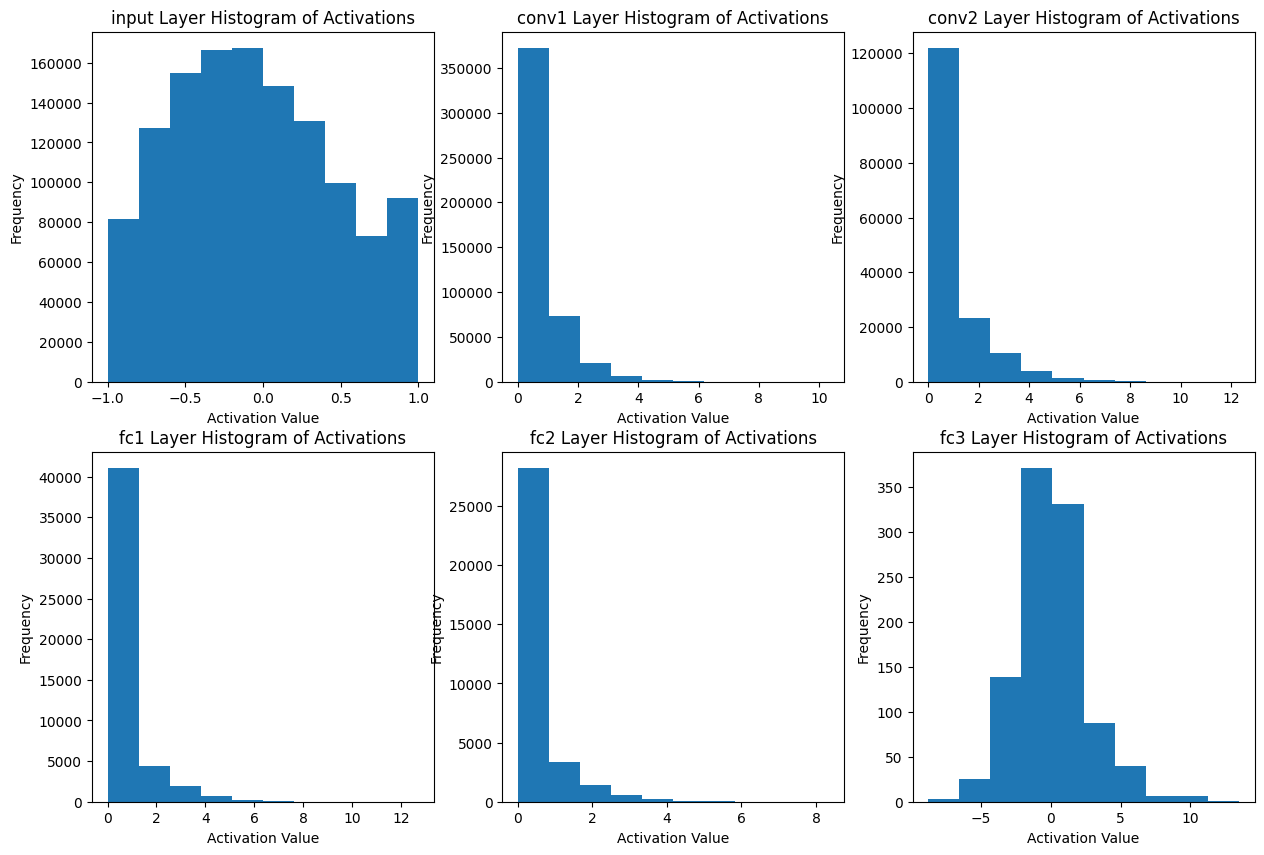

In [27]:
# Plot distributions of activations for each layer

activations = {
    'input': input_activations,
    'conv1': conv1_output_activations,
    'conv2': conv2_output_activations,
    'fc1': fc1_output_activations,
    'fc2': fc2_output_activations,
    'fc3': fc3_output_activations
}

statistics = {
    'input': {},
    'conv1': {},
    'conv2': {},
    'fc1': {},
    'fc2': {},
    'fc3': {}
}

# Create subplots for histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Convert multi-dimensional subplot axes array into a 1D array
axes = axes.flatten()
i = 0
for key in activations:
    # Get layer name and activations
    layer_name = key
    layer_activations = activations[key]

    
    # Store statistics(full range, 3-sigma range) for layer
    activations_range = (layer_activations.min(), layer_activations.max())
    statistics[key]['full_range'] = activations_range
    activations_mean = layer_activations.mean()
    activations_std = layer_activations.std()
    statistics[key]['3-sigma_range'] = (activations_mean - 3 * activations_std, activations_mean + 3 * activations_std)
        
    # Plot histogram of activations for layer
    axes[i].hist(layer_activations)
    axes[i].set_title(layer_name + " Layer Histogram of Activations")
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')
    i += 1

plt.show()

In [28]:
# Calculate and print statistical measures (full range, 3-sigma range) for each layer
# Document distribution patterns across network depth
for key in statistics:
    print(key)
    print("Full Range: " + str(statistics[key]['full_range']))
    print("3 Sigma Range: " + str(statistics[key]['3-sigma_range']))
    print()
    print()

input
Full Range: (-1.0, 1.0)
3 Sigma Range: (-1.6093617983624198, 1.5012448407394523)


conv1
Full Range: (0.0, 10.323747634887695)
3 Sigma Range: (-1.9293176755119321, 3.1215164079295104)


conv2
Full Range: (0.0, 12.310510635375977)
3 Sigma Range: (-2.8966380566793086, 4.453709713946421)


fc1
Full Range: (0.0, 12.71954345703125)
3 Sigma Range: (-2.67623602324843, 3.6837435509826015)


fc2
Full Range: (0.0, 8.341231346130371)
3 Sigma Range: (-1.8511606899638595, 2.5923604948241312)


fc3
Full Range: (-8.797361373901367, 13.489840507507324)
3 Sigma Range: (-7.532655283940421, 7.687392734856851)




Analyze distribution patterns across layers

According to the histrograms, the input layer activations have a kind of evenly distributed distribution while the conv1, conv2, fc1, and fc2 layer activations have distributions that are very positively skewed to the right. The fc3 layer activations have a pretty roughly symmetric distribution though. The input layer activations have a pretty standard range of (-1, 1). The conv1 layer activations are very sparse and positively skewed because of the ReLU function with a slightly larger 3 sigma range than the input layer activations and a much larger full range. The conv2 layer activations are even more positively skewed and have a slightly wider 3 sigma range and full range than the conv2 layer. The fc1 layer activations have a slightly larger full range but tighter 3 sigma range while also still being as positively skewed as the conv2 layer. The fc2 layer activations have a noticeably smaller full range and tighter 3 sigma range and are less positively skewed than the fc1 layer activations. Finally, the fc3 layer activations are more symmetric with a wider overall range than any of the previous layers due to the ReLU activation not being applied to this final layer.

## Question 4: Quantize Activations

In [35]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # 3-Sigma clipping
        mean = pixels.mean()
        std = pixels.std()
        new_min = mean - (3 * std)
        new_max = mean + (3 * std)
        # Defining the range as mean +/- 3*std
        new_range = new_max - new_min
        # Calculate scale((127 - -128) / range)
        scale = 255.0 / new_range
        return scale

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # Calculate the cumulative input scale to this layer
        cumulative_input_scale = n_initial_input
        for weight_scale, output_scale in ns:
            # Each layer multiplies by weight_scale and divides by output_scale
            cumulative_input_scale *= (weight_scale / output_scale)

        # The scale of the output would be: cumulative_input_scale * n_w
        original_output_scale = cumulative_input_scale * n_w

        # 3-Sigma clipping
        mean = activations.mean()
        std = activations.std()
        new_min = mean - (3 * std)
        new_max = mean + (3 * std)
        # Defining the range as mean +/- 3*std
        new_range = new_max - new_min
        # Calculate scale((127 - -128) / range)
        new_scale = 255.0 / new_range

        # The output scale needed is: original_output_scale / new_scale
        output_scale = original_output_scale / new_scale
        return output_scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp

        # scale input and clamp input to [-128, 127]
        x = x * self.input_scale
        x = torch.clamp(x.round(), min=-128, max=127)
        
        # Divide output of conv1 layer by its output scale and clamp output to [-128, 127]
        x = self.conv1(x)
        x = x / self.conv1.output_scale
        x = torch.clamp(x.round(), min=-128, max=127)
        # ReLU
        x = torch.clamp(x, min=0)
        # Pooling
        x = self.pool(x)
        
        # Divide output of conv2 layer by its output scale and clamp output to [-128, 127]
        x = self.conv2(x)
        x = x / self.conv2.output_scale
        x = torch.clamp(x.round(), min=-128, max=127)
        # ReLU
        x = torch.clamp(x, min=0) 
        # Pooling
        x = self.pool(x)
        
        # Flatten
        x = x.view(-1, 16 * 5 * 5)
        
        # Divide output of fc1 layer by its output scale and clamp output to [-128, 127]
        x = self.fc1(x)
        x = x / self.fc1.output_scale
        x = torch.clamp(x.round(), min=-128, max=127)
        # ReLU
        x = torch.clamp(x, min=0)  # ReLU
        
        # Divide output of fc2 layer by its output scale and clamp output to [-128, 127]
        x = self.fc2(x)
        x = x / self.fc2.output_scale
        x = torch.clamp(x.round(), min=-128, max=127)
        # ReLU
        x = torch.clamp(x, min=0) 
        
        # Return output of fc3 layer
        x = self.fc3(x)
        x = x / self.fc3.output_scale
        x = torch.clamp(x.round(), min=-128, max=127)
        # ReLU
        x = torch.clamp(x, min=0) 
        
        return x

In [36]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [37]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 49.79%


Impact on model accuracy

After quantizing all weights and activations to be within int8 range, the accuracy of the network still only dropped by less than 3% on the test set. This shows that 32-bit floating point data may not be necessary during inference since quantizing all the weights and activations to be within int8 range during inference achieved pretty comparable performance.

## Question 5: Quantize Biases

In [38]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

In [39]:
train(net_with_bias, trainloader)

[1,  2000] loss: 2.207
[1,  4000] loss: 1.895
[1,  6000] loss: 1.704
[1,  8000] loss: 1.614
[1, 10000] loss: 1.556
[1, 12000] loss: 1.519
[2,  2000] loss: 1.448
[2,  4000] loss: 1.417
[2,  6000] loss: 1.379
[2,  8000] loss: 1.370
[2, 10000] loss: 1.318
[2, 12000] loss: 1.329
Finished Training


In [40]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 52.55%


In [41]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [42]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 48.09%


Impact on model accuracy

After quantizing all weights to be within int8 range but not the bias, the accuracy of the network dropped by more than 4% on the test set. This shows that only quantizing all the weights to be within int8 range without quantizing the bias in some way hurts the performance more during inference.

In [43]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)

        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )

        if (self.fc3.bias.data < -2147483648).any() or (self.fc3.bias.data > 2147483647).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        # Calculate the cumulative input scale to this layer
        cumulative_input_scale = n_initial_input
        for weight_scale, output_scale in ns:
            # Each layer multiplies by weight_scale and divides by output_scale
            cumulative_input_scale *= (weight_scale / output_scale)

        # The scale of the bias would be: cumulative_input_scale * n_w
        bias_scale = cumulative_input_scale * n_w

        # Round and clamp the quantized_bias to range [-2147483648, 2147483647]
        quantized_bias = (bias * bias_scale).round()
        quantized_bias = torch.clamp(quantized_bias, min=-2147483648, max=2147483647)
        return quantized_bias

In [44]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [45]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 49.93%


Impact on model accuracy

After quantizing all weights to be within int8 range and quantizing the bias to be within the 32-bit range, the accuracy of the network dropped by less. This shows that only quantizing all the weights to be within int8 range and quantizing the bias in some way does a better job of achieving a comparable performance during inference.

Discussion of trade-offs

Overall, the results from this experiment show that post-training quantization techniques for inference actually do a pretty good job of maintaining the performance of small pre-trained models while also saving computentionally expensive cost in terms of area, performance, and energy. So post-training quantization is actually worth it and high precision might not be necessary in these cases.